##  1. Data Accessing:

In [ ]:
!pip install tensorflow

In [ ]:
!pip install rasterio matplotlib scikit-learn opencv-python

In [ ]:
import os
import cv2
import rasterio
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/DEPI/Processed_Data"
print(os.listdir(data_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['RGB', 'RGB_NIR', 'NDVI']


In [ ]:
rgb_path='/content/drive/MyDrive/DEPI/Processed_Data/RGB'
rgb_nir_path = '/content/drive/MyDrive/DEPI/Processed_Data/RGB_NIR'
ndvi_path ='/content/drive/MyDrive/DEPI/Processed_Data/NDVI'

print("RGB shape:", os.listdir(rgb_path))
print("RGB + NIR shape:", os.listdir(rgb_nir_path))
print("NDVI shape:", os.listdir(ndvi_path))

RGB shape: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'SeaLake', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River']
RGB + NIR shape: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'SeaLake', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River']
NDVI shape: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'SeaLake', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River']


In [ ]:
def count_images_in_folders(root_path):
    for main_dir in os.listdir(root_path):
        main_dir_path = os.path.join(root_path, main_dir)
        if not os.path.isdir(main_dir_path):
            continue

        print(f"\n{main_dir} Folder:")
        total_images = 0

        for category in os.listdir(main_dir_path):
            category_path = os.path.join(main_dir_path, category)
            if not os.path.isdir(category_path):
                continue

            image_count = len([
                file for file in os.listdir(category_path)
            ])

            total_images += image_count
            print(f"-------->  {category}: {image_count} images")

        print(f"\n======>   Total in {main_dir}: {total_images} images")


In [ ]:
count_images_in_folders(data_path)


RGB Folder:
-------->  AnnualCrop: 5742 images
-------->  Forest: 5998 images
-------->  HerbaceousVegetation: 2548 images
-------->  SeaLake: 6000 images
-------->  Highway: 5000 images
-------->  Industrial: 5000 images
-------->  Pasture: 4000 images
-------->  PermanentCrop: 4350 images
-------->  Residential: 6000 images
-------->  River: 4947 images

======>   Total in RGB: 49585 images

RGB_NIR Folder:
-------->  AnnualCrop: 2871 images
-------->  Forest: 2999 images
-------->  HerbaceousVegetation: 1273 images
-------->  SeaLake: 3000 images
-------->  Highway: 2500 images
-------->  Industrial: 2500 images
-------->  Pasture: 2000 images
-------->  PermanentCrop: 2175 images
-------->  Residential: 3000 images
-------->  River: 2474 images

======>   Total in RGB_NIR: 24792 images

NDVI Folder:
-------->  AnnualCrop: 2871 images
-------->  Forest: 2999 images
-------->  HerbaceousVegetation: 1274 images
-------->  SeaLake: 3000 images
-------->  Highway: 2500 images
-------->

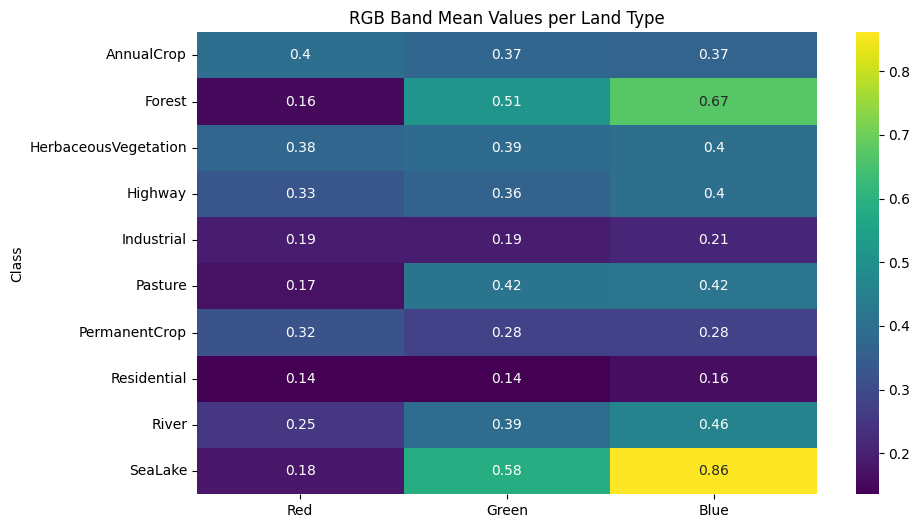

In [ ]:
def visualize_rgb_correlation(base_dir=rgb_path, n_samples=10):
    bands = ['Red', 'Green', 'Blue']
    land_types = sorted(os.listdir(base_dir))
    data = []

    for land_type in land_types:
        class_path = os.path.join(base_dir, land_type)
        files = [f for f in os.listdir(class_path) if f.endswith('.npy')][:n_samples]

        for file in files:
            img = np.load(os.path.join(class_path, file))
            means = img.mean(axis=(0, 1))
            data.append(dict(zip(bands, means)) | {'Class': land_type})

    df = pd.DataFrame(data)
    df_grouped = df.groupby("Class").mean()

    plt.figure(figsize=(10, 6))
    sns.heatmap(df_grouped, annot=True, cmap='viridis')
    plt.title("RGB Band Mean Values per Land Type")
    plt.show()
visualize_rgb_correlation()

In [ ]:
target_path = "/content/drive/MyDrive/DEPI/Processed_Data/RGB"


In [ ]:
os.listdir(target_path)

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'SeaLake',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River']

In [ ]:
def load_npy_dataset(base_path, dataset_type):
    data_path = os.path.join(base_path, dataset_type)

    images = []
    labels = []
    class_names = sorted(os.listdir(data_path))
    class_to_idx = {cls: i for i, cls in enumerate(class_names)}

    print("Detected classes:", class_to_idx)

    for cls in class_names:
        class_folder = os.path.join(data_path, cls)
        for file in os.listdir(class_folder):
            if file.endswith(".npy"):
                arr = np.load(os.path.join(class_folder, file))


                arr = arr.astype("float32")

                #(64,64) -> (64,64,1)
                if arr.ndim == 2:
                    arr = np.expand_dims(arr, axis=-1)

                images.append(arr)
                labels.append(class_to_idx[cls])

    images = np.array(images, dtype="float32")
    labels = np.array(labels)

    print("\nLoaded dataset info:")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Channels:", images.shape[-1])

    return images, labels, class_names


In [ ]:
base_path = "/content/drive/MyDrive/DEPI/Processed_Data"
dataset_type = "RGB"
images, labels, class_names = load_npy_dataset(base_path, dataset_type)

Detected classes: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}

Loaded dataset info:
Images shape: (49585, 64, 64, 3)
Labels shape: (49585,)
Channels: 3


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, shuffle=True, stratify=labels
)

In [ ]:
import tensorflow as tf
BATCH_SIZE = 32
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val))
train_ds = train_ds.shuffle(5000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model_rgb = Sequential([
    Conv2D(32, (3, 3),input_shape=(64, 64, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model_rgb.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_rgb.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             

 Total params: 2,329,162 (8.89 MB)

 Trainable params: 2,326,666 (8.88 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [ ]:
#EXECUTE CNN
model_rgb.fit(train_ds, epochs=10, validation_data=val_ds, verbose=1, batch_size=32, shuffle=True)


Epoch 1/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 611s 489ms/step - accuracy: 0.5259 - loss: 1.4344 - val_accuracy: 0.7487 - val_loss: 0.7428
Epoch 2/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 608s 489ms/step - accuracy: 0.7524 - loss: 0.7712 - val_accuracy: 0.7872 - val_loss: 0.6287
Epoch 3/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 607s 489ms/step - accuracy: 0.8388 - loss: 0.5312 - val_accuracy: 0.8749 - val_loss: 0.3892
Epoch 4/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 591s 477ms/step - accuracy: 0.8766 - loss: 0.4163 - val_accuracy: 0.8639 - val_loss: 0.4383
Epoch 5/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 591s 477ms/step - accuracy: 0.8932 - loss: 0.3570 - val_accuracy: 0.8691 - val_loss: 0.4199
Epoch 6/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 592s 477ms/step - accuracy: 0.9113 - loss: 0.2922 - val_accuracy: 0.8326 - val_loss: 0.5249
Epoch 7/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 592s 477ms/step - accuracy: 0.9253 - loss: 0.2501 - val_accuracy: 0.9221 - val_loss: 0.2498
Epoch 8/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 591s 477ms/step - ac

In [ ]:
print("\nEvaluating the model:")
loss, accuracy = model_rgb.evaluate(X_val, y_val, batch_size=24)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


Evaluating the model:
414/414 ━━━━━━━━━━━━━━━━━━━━ 27s 65ms/step - accuracy: 0.9407 - loss: 0.2060
Validation Loss: 0.1956
Validation Accuracy: 0.9418


310/310 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step


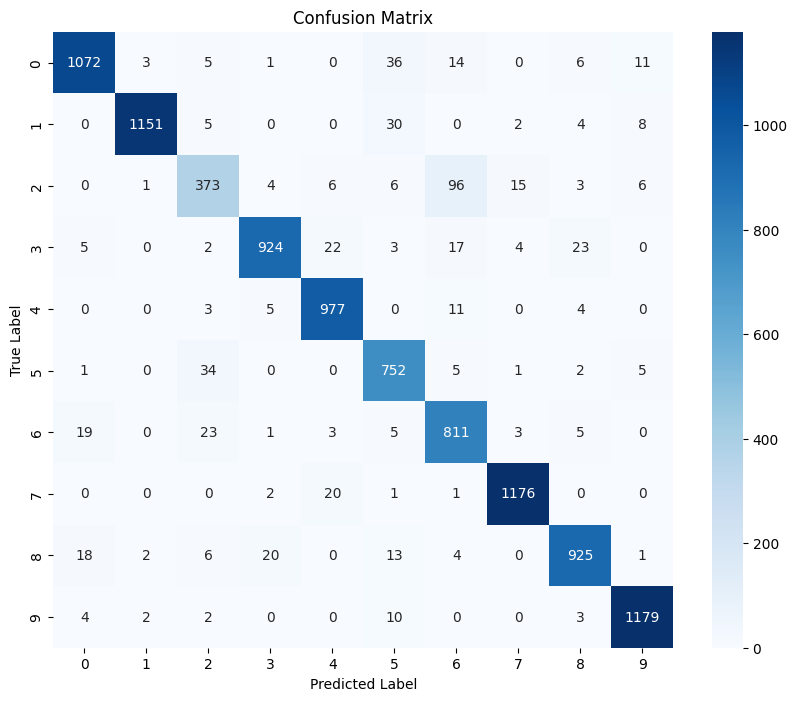

In [ ]:
y_pred_proba = model_rgb.predict(X_val)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = y_val
cm = confusion_matrix(y_true, y_pred)
classes = np.arange(len(np.unique(y_true)))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_rgb.save('model_rgb_v1.h5')

In [ ]:
model_rgb.save('my_model.keras')


In [ ]:
from tensorflow.keras.models import load_model
model_rgb = load_model('my_model.keras')

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 32 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:

from google.colab import files
files.download('my_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('model_rgb_v1.h5')